# Store Sales - Time Series Forecasting

Data source: [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

This section is part of exercise in [Time Series Analysis course](https://www.kaggle.com/code/thituyetmaitran/exercise-linear-regression-with-time-series/edit), available on Kaggle.

Constraints: The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (average_sales) of the average sales each day.

## Linear Regression

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

store_sales = pd.read_csv("raw_data/train.csv")
store_sales.drop(columns=['id'], inplace=True, axis=1)
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales = store_sales.set_index("date").to_period("D")
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

df_sales_avg = store_sales.groupby("date")['sales'].mean().to_frame()
display(df_sales_avg.head(1))

,sales
date,
2013-01-01,1.409438


In [3]:
plot_params = {
    'kind': 'line',  # Plot type (line, scatter, bar, etc.)
    'color': 'grey',  # Line color
    'figsize': (20, 3),  # Figure size (width, height)
    'linewidth': 1,  # Line width
    'marker': 'o',  # Marker style for data points (optional)
    'markersize': 3,  # Marker size (optional)
    'grid': True,  # Display grid lines
    'title': 'Average Daily Sales',  # Plot title
    'xlabel': 'Date',  # X-axis label
    'ylabel': 'Sales',  # Y-axis label
    'legend': True  # Include legend if multiple data series are plotted
}

### Fit a time-step feature

Linear Regression Model - Time-Step Feature:
Sales = 194.2328 + 0.1943 * Time


date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Freq: D, Length: 1684, dtype: float64

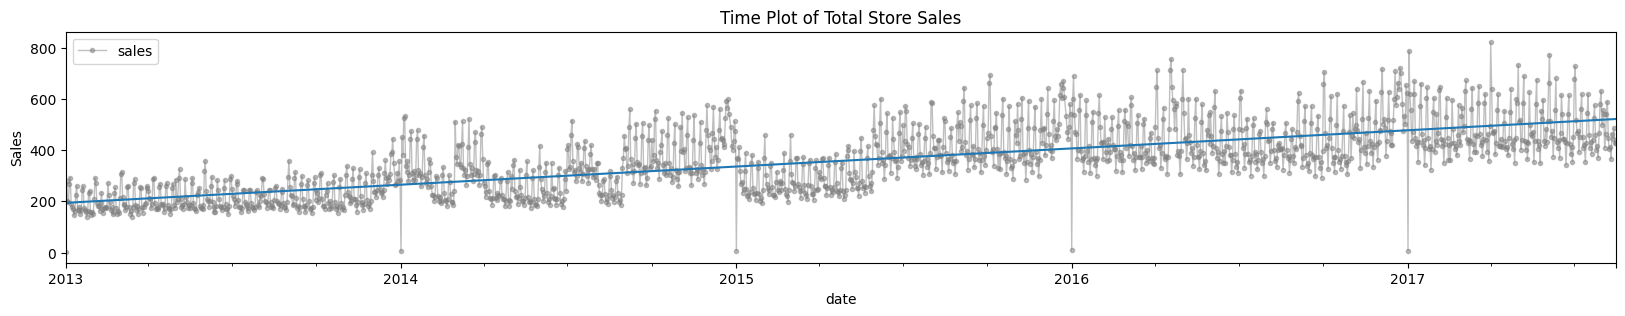

In [4]:
# create a time dummy
df_sales_avg['time'] = np.arange(len(df_sales_avg.index))
# create a training data
x = df_sales_avg[['time']] # feature
y = df_sales_avg['sales'] # target
# train a model
model = LinearRegression()
model.fit(x, y)
# define the equation 
print("Linear Regression Model - Time-Step Feature:")
print(f"Sales = {model.intercept_:.4f} + {model.coef_[0]:.4f} * Time")
# store the fitted values as a time series wit the same time index as the training data
y_pred = pd.Series(model.predict(x), index=x.index)
display(y_pred)
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax)
ax.set_title('Time Plot of Total Store Sales')
plt.show()

### Fit a lag feature

Linear Regression Model - Lag Feature:
Sales = 84.2231 + 0.7653 * Time
date
2013-01-02     85.301711
2013-01-03    297.268221
2013-01-04    239.451339
2013-01-05    236.444547
2013-01-06    289.219409
                 ...    
2017-08-11    363.958887
2017-08-12    439.106347
2017-08-13    424.615456
2017-08-14    455.968972
2017-08-15    410.998514
Freq: D, Length: 1683, dtype: float64


[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'lag_1'),
 Text(0.5, 1.0, 'Lag Plot of Average Sales')]

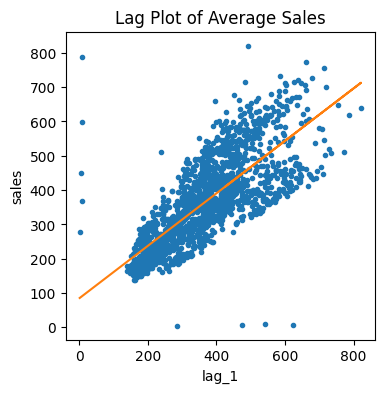

In [5]:
df_sales_avg['lag_1'] = df_sales_avg['sales'].shift(1)
df_sales_avg.dropna(inplace=True)
# create a training data
x = df_sales_avg[['lag_1']]
y = df_sales_avg['sales']
# fit the model
model = LinearRegression()
model.fit(x, y)
# define the equation 
print("Linear Regression Model - Lag Feature:")
print(f"Sales = {model.intercept_:.4f} + {model.coef_[0]:.4f} * Time")
# store the fitted values as a time series wit the same time index as the training data
y_pred = pd.Series(model.predict(x), index=x.index)
print(y_pred)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x['lag_1'], y, '.')
ax.plot(x['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales')
# ax.set_title('Time Plot of Total Store Sales')
# plt.show()

## Trend

[Text(0.5, 1.0, 'Daily Average Sales')]

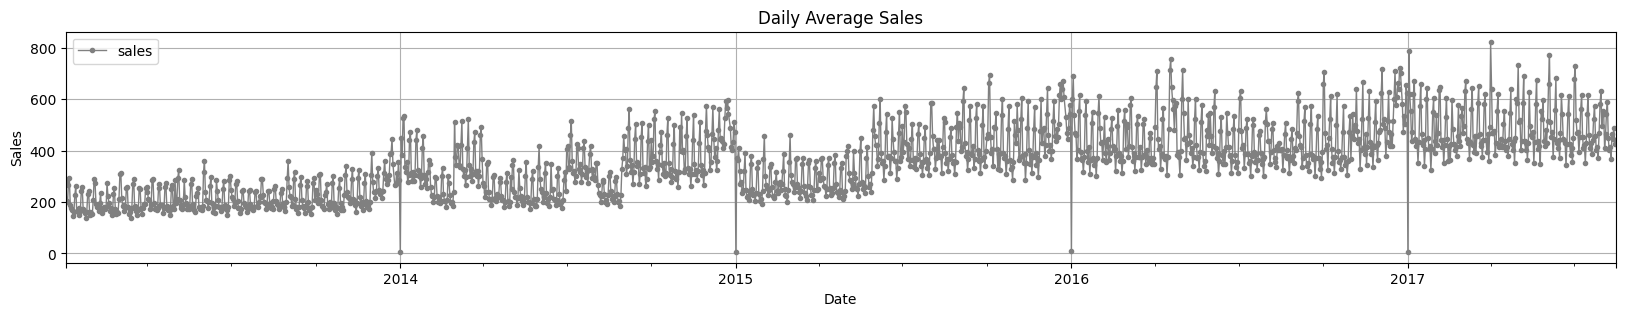

In [6]:
ax = df_sales_avg[['sales']].plot(**plot_params)
ax.set(title="Daily Average Sales")

### Moving Average

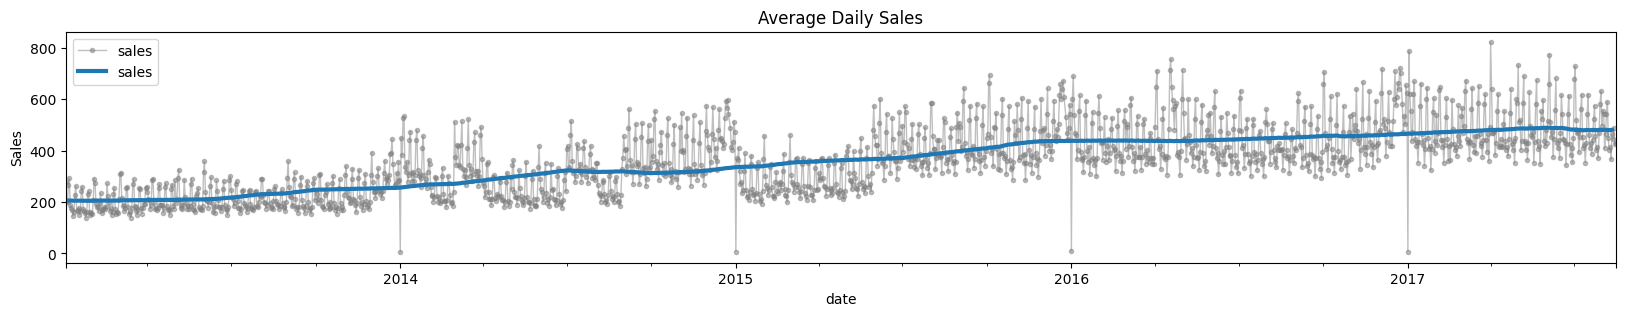

In [7]:
trend = df_sales_avg[['sales']].rolling(
    window=365,
    center=True,
    min_periods=187
).mean()

ax = df_sales_avg[['sales']].plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Create a trend feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

A deterministic process is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.

Notice that the `const` feature from the DeterministicProcess is  

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = df_sales_avg['sales'].copy() # the target

dp = DeterministicProcess(
    index=y.index, # dates as index in the training data
    constant=True, # dummy feature for the bias (y_intercept)
    order=3, # time dummy (trend) - 1=linear, 2=quadratic, 3=cubic
    drop=True # drop terms if necessary to avoid collinearity
)
X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument
display(X.head())
X_fore = dp.out_of_sample(steps=90) # Create features for a 90-day forecast
display(X_fore)

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-02,1.0,1.0,1.0,1.0
2013-01-03,1.0,2.0,4.0,8.0
2013-01-04,1.0,3.0,9.0,27.0
2013-01-05,1.0,4.0,16.0,64.0
2013-01-06,1.0,5.0,25.0,125.0


,const,trend,trend_squared,trend_cubed
2017-08-16,1.0,1684.0,2835856.0,4.775582e+09
2017-08-17,1.0,1685.0,2839225.0,4.784094e+09
2017-08-18,1.0,1686.0,2842596.0,4.792617e+09
2017-08-19,1.0,1687.0,2845969.0,4.801150e+09
2017-08-20,1.0,1688.0,2849344.0,4.809693e+09
...,...,...,...,...
2017-11-09,1.0,1769.0,3129361.0,5.535840e+09
2017-11-10,1.0,1770.0,3132900.0,5.545233e+09
2017-11-11,1.0,1771.0,3136441.0,5.554637e+09
2017-11-12,1.0,1772.0,3139984.0,5.564052e+09


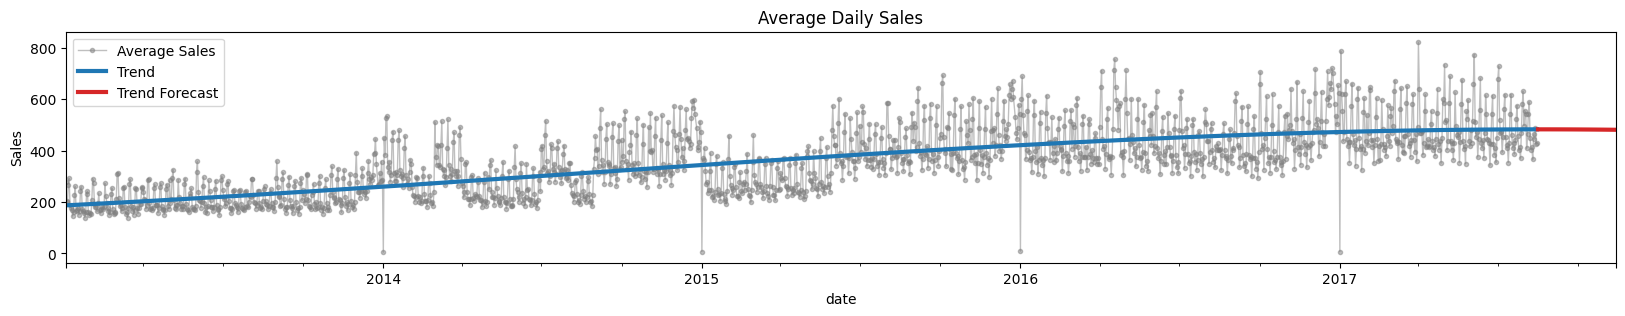

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, label="Average Sales")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

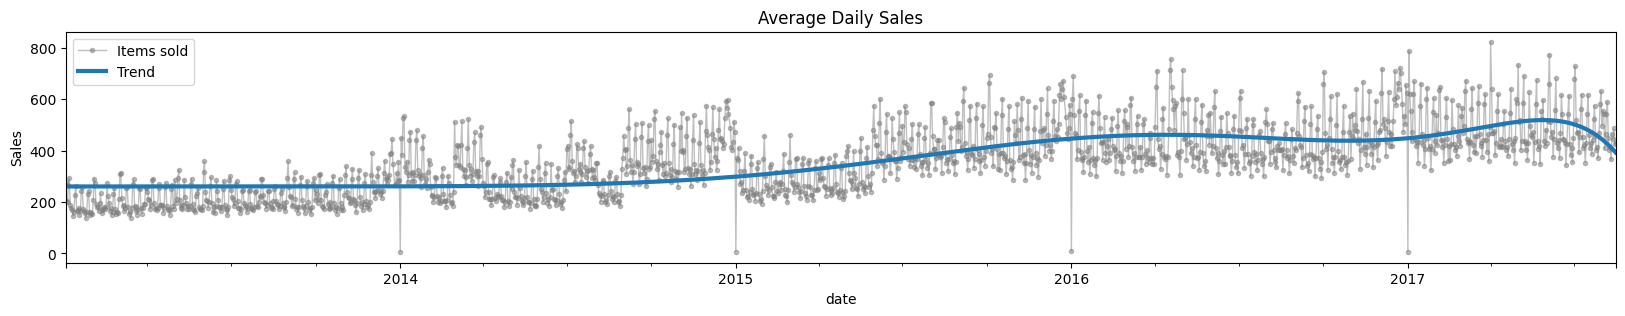

In [10]:
# increase the order of the polynominal to 11 to fit more complicated trends. 
# however, high-order polyniminals contain risks of forecasting 
# eg. An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable. 
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, label="Items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend()

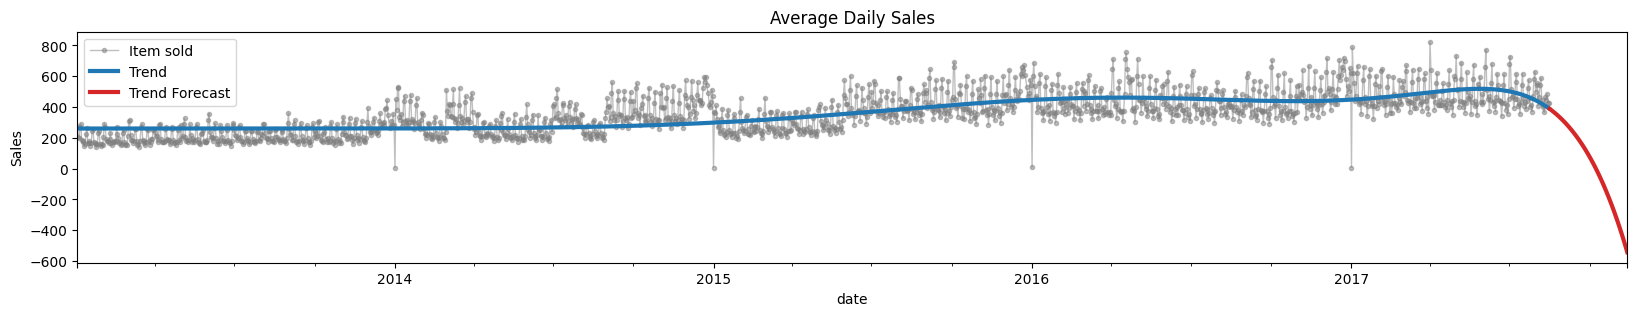

In [11]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, label="Item sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

## Seasonality

Define functions to visualize seasonal plot and plot periodogram 

### Seasonal Plot and Plotting Periodogram

In [12]:
# define functions
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10,5))
    print(X[period].nunique())
    palette = sns.color_palette("husl", n_colors=X[period].nunique())
    ax = sns.lineplot(
        x=freq, 
        y=y,
        hue=period, 
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False
    )       
    ax.set_title(f"Seasonal Plot")

    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",

        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")

    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(20,5))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    ax.grid(True, which='both', linestyle='-', linewidth=0.5)
    return ax

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.



,sales,time,lag_1
date,,,
2013-01-02,278.390807,1,1.409438


34


<Axes: title={'center': 'Seasonal Plot'}, xlabel='weekday', ylabel='sales'>

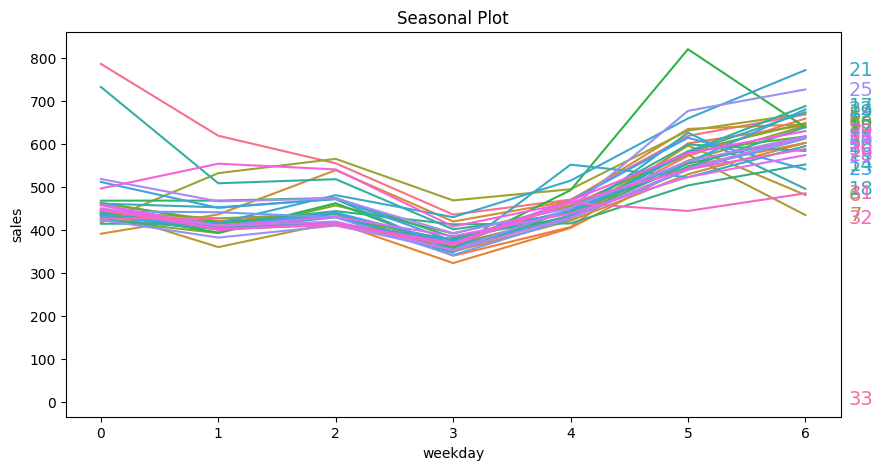

In [13]:
display(df_sales_avg.head(1))
df_season = df_sales_avg.reset_index()[df_sales_avg.reset_index()['date'].dt.year==2017].set_index('date') # filter for time series in 2017 only
df_season['weeknum'] = df_season.index.week
df_season['weekday'] = df_season.index.weekday

seasonal_plot(X=df_season, y='sales', period='weeknum', freq='weekday')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

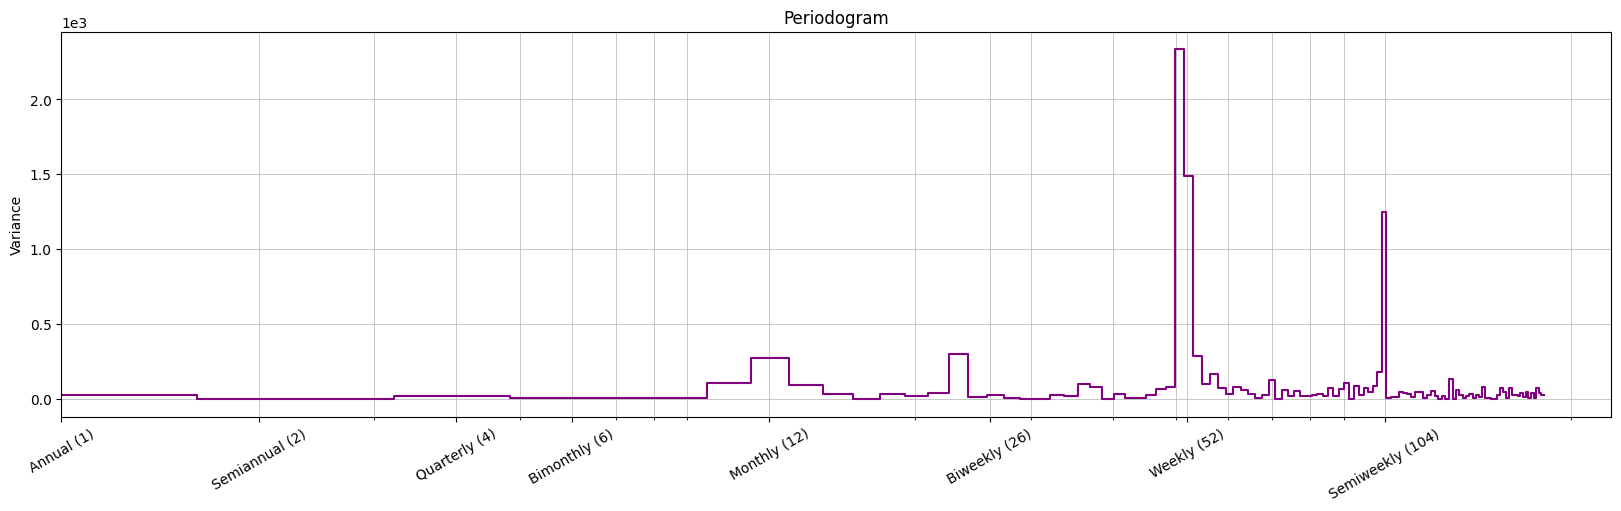

In [14]:
plot_periodogram(df_season['sales'])

### Create Seasonal Features

Use DeterministicProcess and CalendarFourier to create:

- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


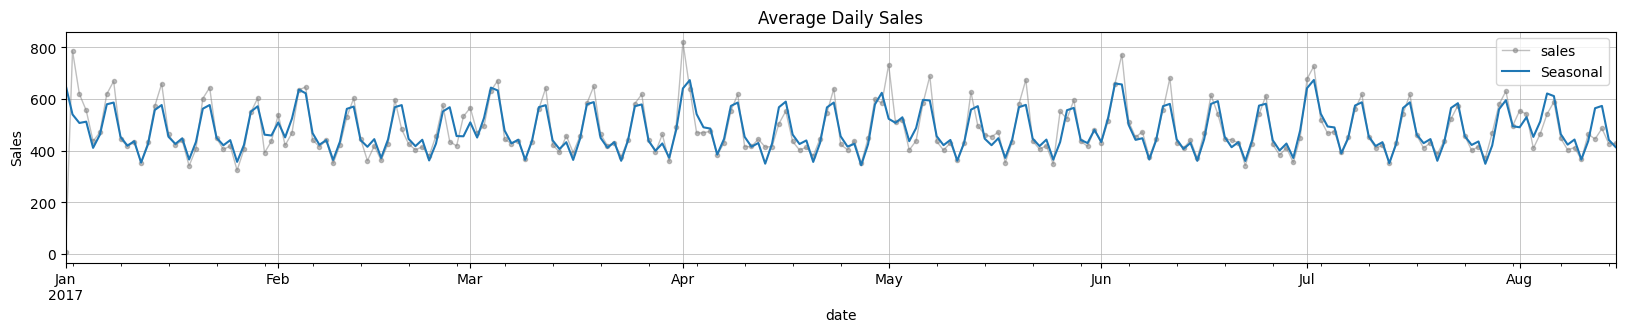

In [15]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

y = df_season['sales'].copy()
fourier = CalendarFourier(freq="M", order=4) # a four sin/cos pairs for monthly ("M") seasonality

dp = DeterministicProcess(
    index=y.index, 
    constant=True, 
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()
display(X.head(1))

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, label="sales")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.grid(True, linestyle='-', linewidth=0.5)
ax.legend()

### Detrending or Deseasonalizing

Removing from a series its trend or seasons

Text(0.5, 1.0, 'Deseasonalized')

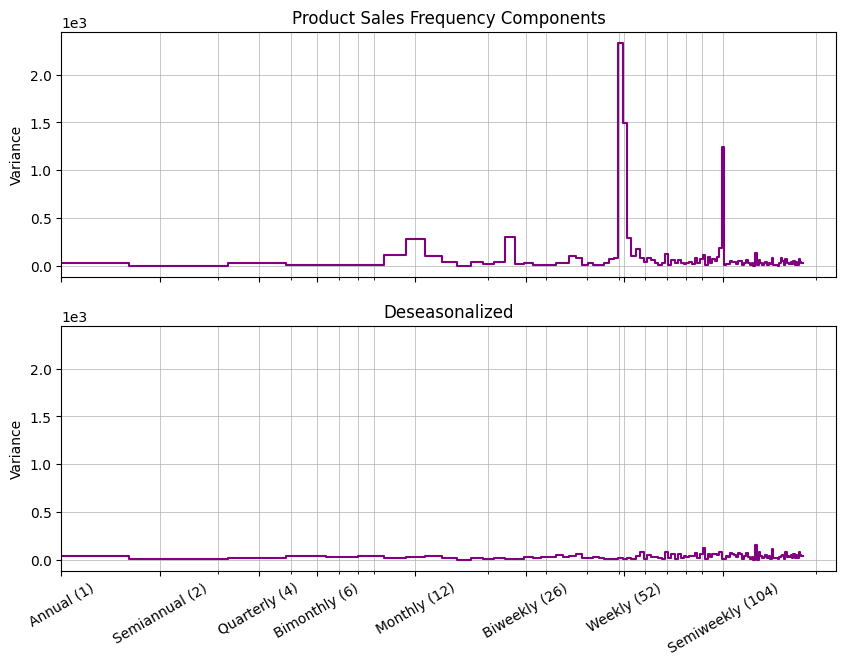

In [16]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized")

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

Examine the seasonality further by looking at Ecuadorian holidays.

date           datetime64[ns]
description            object
dtype: object


,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi


date     datetime64[ns]
sales           float64
dtype: object


Text(0.5, 1.0, 'National and Regional Holidays')

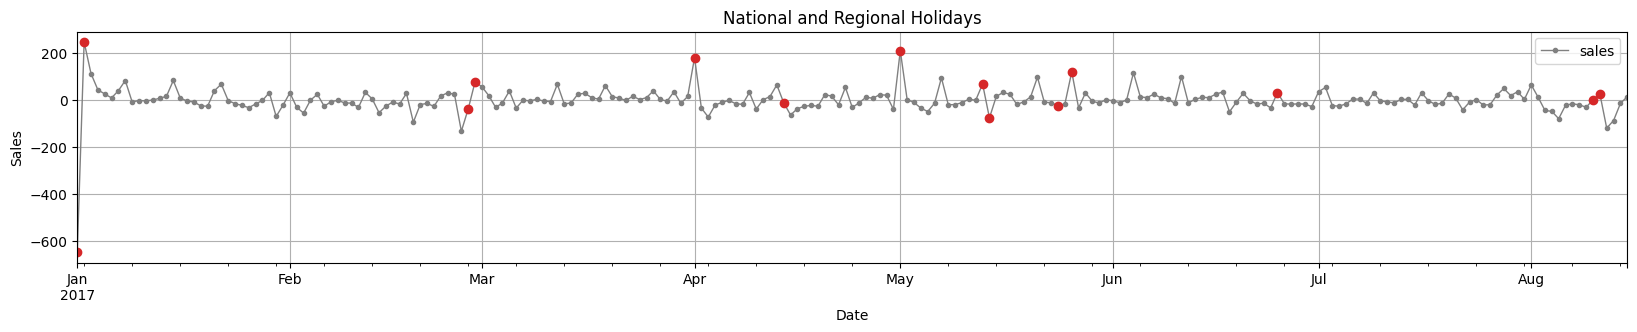

In [17]:
holidays_events = pd.read_csv("raw_data/holidays_events.csv")

holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays = holidays_events[(holidays_events['locale'].isin(['National', 'Regional']))&(holidays_events['date'].dt.year==2017)][['date', 'description']]
print(holidays.dtypes)
holidays = holidays.set_index("date")
display(holidays.head())

y_deseason = y - y_pred
y_deseason = y_deseason.to_frame('sales')
y_deseason = y_deseason.reset_index()
y_deseason['date'] = y_deseason['date'].dt.to_timestamp()
print(y_deseason.dtypes)
y_deseason = y_deseason.set_index('date')

ax = y_deseason.plot(**plot_params)
y_deseason_holidays = y_deseason[y_deseason.index.isin(holidays.index)]
plt.plot_date(y_deseason_holidays.index, y_deseason_holidays['sales'], color='C3')
ax.set_title('National and Regional Holidays')

### Create holiday features

In [18]:
# ALTERNATIVE WITH ONE HOT ENCODER FROM SKLEARN
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse=False)

# X_holidays = pd.DataFrame(
#     ohe.fit_transform(holidays),
#     index=holidays.index,
#     columns=holidays.description.unique(),
# )


# # Pandas solution
# X_holidays = pd.get_dummies(holidays)


# # Join to training data
# X2 = X.join(X_holidays, on='date').fillna(0.0)
# print(X2)

# -------------------------------------------------------------------------------------------------
X_holidays = pd.get_dummies(holidays['description'])
display(X_holidays.head(1))
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2.head(1)

,Batalla de Pichincha,Carnaval,Dia de Difuntos,Dia de la Madre,Dia de la Madre-1,Dia del Trabajo,Independencia de Cuenca,Independencia de Guayaquil,Navidad,Navidad+1,...,Primer Grito de Independencia,Primer dia del ano,Provincializacion Santa Elena,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,Primer Grito de Independencia,Primer dia del ano,Provincializacion Santa Elena,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Time Series as Features

In [19]:
def time_series_plot(series, ax=None, **kwargs): # use **kwargs to allow for passing additional keyword arguments 
    if ax is None:
        _, ax = plt.subplots(figsize=(10,2))

    ax = series.plot(ax=ax)
    ax.grid(True, color='grey', alpha=0.5)
    ax.set_title("Sales of School and Office Supplies")
    return ax

Deseasonalizing:-----------------------------------------------------------------------------------------------------


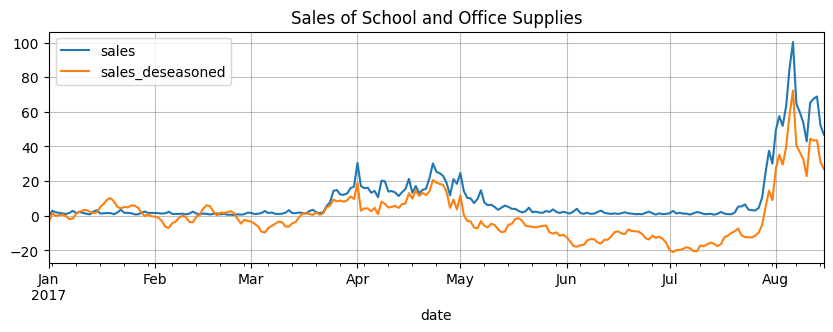

In [20]:
df_supply_sales = store_sales.copy()
df_supply_sales = df_supply_sales.reset_index()
df_supply_sales = df_supply_sales[df_supply_sales['family']=='SCHOOL AND OFFICE SUPPLIES']
df_supply_sales = df_supply_sales[df_supply_sales['date'].dt.year==2017]
df_supply_sales = df_supply_sales.groupby("date").agg({'sales':'mean', 'onpromotion':'mean'})
df_supply_sales

print("Deseasonalizing:-----------------------------------------------------------------------------------------------------")
y = df_supply_sales['sales'].squeeze() # create a Pandas Series
fourier = CalendarFourier(freq='M', order=4) # Create 4 sin-cos aka Fourier pairs for Monthly seasonality
 
dp = DeterministicProcess(
    constant=True, 
    index=y.index,
    order=1,  # a linear trend, as the trend component follows a straight line
    seasonal=True, # include seasonal terms
    drop=True, # drop missing values from the data before fitting the deterministic process
    additional_terms=[fourier] # the Fourier terms generated by the CalendarFourier() function are added to capture seasonal patterns.
)
X = dp.in_sample()

model = LinearRegression(fit_intercept=False)
model.fit(X,y)
y_deseason = y - model.predict(X)
y_deseason.name = 'sales_deseasoned'

# Visualization
# _, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
# time_series_plot(df_supply_sales['sales'], ax=axes[0])
# time_series_plot(y_deseason, ax=axes[1], color='red')
# plt.show()

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
time_series_plot(df_supply_sales['sales'], ax=axes)
time_series_plot(y_deseason, ax=axes)
plt.legend()
plt.show()

Questions to be asked: Does this deseasonalized series show cyclic patterns? We'll isolate cyclic behavior using a MA plot. 

The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

### Plotting cycles

Creating a seven-day moving average plot:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


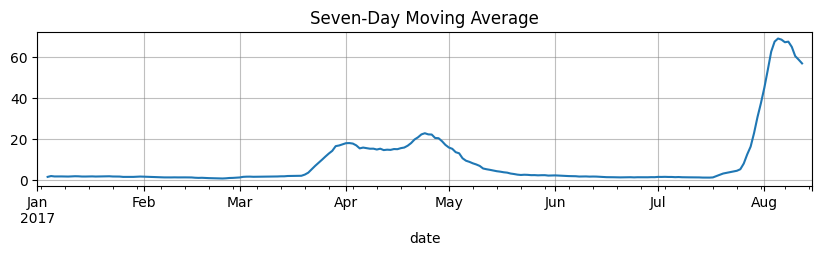

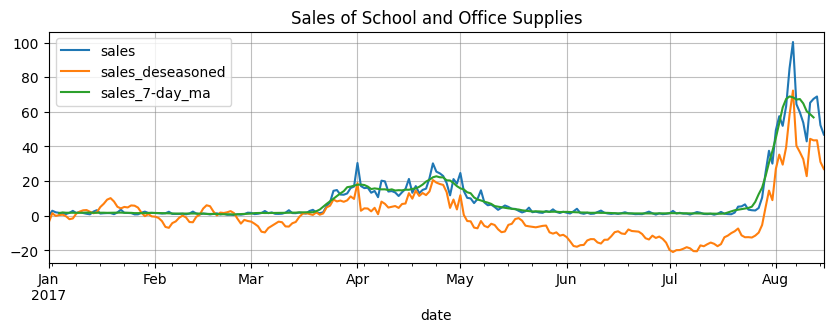

In [21]:
print("Creating a seven-day moving average plot:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

y_ma = df_supply_sales['sales'].rolling(
    window=7,
    center=True
).mean()
y_ma.name = 'sales_7-day_ma'
ax = time_series_plot(y_ma)
ax.set_title("Seven-Day Moving Average")


_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
time_series_plot(df_supply_sales['sales'], ax=axes)
time_series_plot(y_deseason, ax=axes)
time_series_plot(y_ma, ax=axes, color='red')

plt.legend()
plt.show()

### Partial autocorrelation correlogram and Lag plot => Examine Serial Dependence

Plotting partial autocorrelation correlogram and lag plot: ---------------------------------------------------------------------------------------------------------------------------------


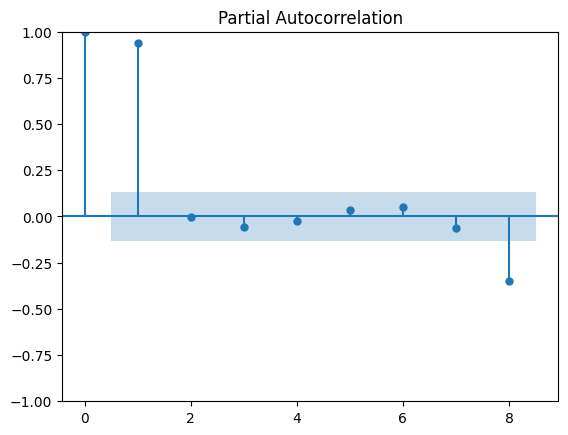

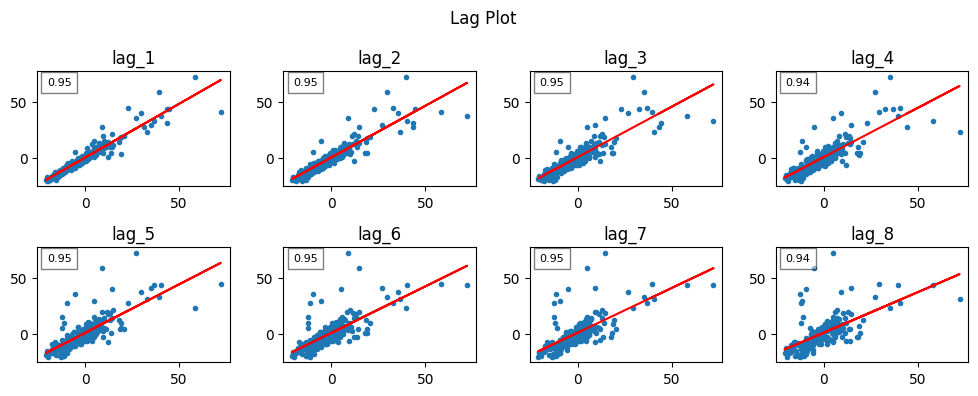

In [23]:
print("Plotting partial autocorrelation correlogram and lag plot: ---------------------------------------------------------------------------------------------------------------------------------")
# Partial Autocorrelation Correlogram
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_deseason, lags=8)
plt.show()

# Lag Plot
df_lag = y_deseason.reset_index().set_index('date').copy()
for i in range(1, 9):
    df_lag[f'lag_{i}'] = df_lag['sales_deseasoned'].shift(i)
df_lag.dropna(inplace=True)
y = df_lag['sales_deseasoned']

# n_cols = min(3, length)
# n_rows = math.ceil(length / n_cols)
ncols = 4
nrows = 2
_, ax = plt.subplots(figsize=(10, 4), ncols=ncols, nrows=nrows)
for i in range(1, 9):
    # fit the model
    model = LinearRegression()
    model.fit(df_lag[[f'lag_{i}']], y)
    # predicted/fitted values 
    y_pred = pd.Series(model.predict(df_lag[[f'lag_{i}']]), index=df_lag[f'lag_{i}'].index)

    row_index = (i - 1) // ncols
    col_index = (i - 1) % ncols
    ax[row_index, col_index].plot(df_lag[f'lag_{i}'], df_lag['sales_deseasoned'], '.')
    ax[row_index, col_index].plot(df_lag[f'lag_{i}'], y_pred, color='red')
    ax[row_index, col_index].set_title(f'lag_{i}')
    ax[row_index, col_index].text(0.05, 0.95, round(df_lag[f'lag_{i}'].autocorr(), 2), transform=ax[row_index, col_index].transAxes, fontsize=8,
                                  verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.suptitle("Lag Plot")
plt.tight_layout()
plt.show()

The lag plots indicate the relationship of `sales_deseasoned` to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1 and 2. 
The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. 